In [1]:
import dask.dataframe as dd
import dask.distributed
import numpy as np

In [2]:
client = dask.distributed.Client()

In [3]:
df0 = dd.read_parquet('/data/all_trips.parquet', engine='fastparquet', index='pickup_datetime')
df0.columns

Index(['dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
       'dropoff_taxizone_id', 'ehail_fee', 'extra', 'fare_amount',
       'improvement_surcharge', 'mta_tax', 'passenger_count', 'payment_type',
       'pickup_latitude', 'pickup_longitude', 'pickup_taxizone_id',
       'rate_code_id', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'trip_type', 'vendor_id', 'trip_id'],
      dtype='object')

In [4]:
df = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                     columns=[
#                         'pickup_datetime', 
        'pickup_longitude', 'pickup_latitude',
#                         'dropoff_datetime', 
        'dropoff_longitude', 'dropoff_latitude',
#                         'trip_type', 
#         'passenger_count'
        'total_amount'
                    ])


In [5]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.965919        40.771244         -73.949608         40.777058   
1        -73.997482        40.725952         -74.005936         40.735703   
2        -73.964798        40.767391         -73.977753         40.773746   
3        -74.011597        40.708832         -74.013466         40.709358   
4        -74.000648        40.718578         -73.944580         40.712368   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [6]:
df.tail()

pickup_longitude  pickup_latitude  dropoff_longitude  \
1432504               NaN              NaN                NaN   
1432505               NaN              NaN                NaN   
1432506               NaN              NaN                NaN   
1432507               NaN              NaN                NaN   
1432508               NaN              NaN                NaN   

         dropoff_latitude  total_amount  
1432504               NaN      8.300000  
1432505               NaN     17.299999  
1432506               NaN     41.759998  
1432507               NaN      6.300000  
1432508               NaN     14.300000

In [7]:
df = df[df.pickup_latitude.notnull() & df.pickup_longitude.notnull() 
        & ((df.pickup_latitude - 40.75).abs() <= 0.5) 
        & ((df.pickup_longitude + 73.9).abs() <= 0.5)
       ]
df = df[df.dropoff_latitude.notnull() & df.dropoff_longitude.notnull() 
        & ((df.dropoff_latitude - 40.75).abs() <= 0.5) 
        & ((df.dropoff_longitude + 73.9).abs() <= 0.5)
       ]

In [8]:
df.count().compute()

pickup_longitude     1268170371
pickup_latitude      1268170371
dropoff_longitude    1268170371
dropoff_latitude     1268170371
total_amount         1268170371
dtype: int64

In [9]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.965919        40.771244         -73.949608         40.777058   
1        -73.997482        40.725952         -74.005936         40.735703   
2        -73.964798        40.767391         -73.977753         40.773746   
3        -74.011597        40.708832         -74.013466         40.709358   
4        -74.000648        40.718578         -73.944580         40.712368   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [10]:
def convert_lon(d, latvar):
    k = d[latvar].copy()
    k = (20037508.34 / 180) * (np.log(np.tan((90. + d[latvar]) * np.pi/360))/(np.pi/180.))
    return k

In [11]:
df['pickup_longitude'] = df.pickup_longitude * (20037508.34 / 180)
df['pickup_latitude'] = df.map_partitions(convert_lon, 'pickup_latitude')
df['dropoff_longitude'] = df.dropoff_longitude * (20037508.34 / 180)
df['dropoff_latitude'] = df.map_partitions(convert_lon, 'dropoff_latitude')

In [12]:
df.repartition(npartitions=200).to_parquet('/tmp/filtered.parquet', compression='SNAPPY')


In [13]:
df = dd.read_parquet('/tmp/filtered.parquet')

In [14]:
# df = client.persist(df.sample(frac=0.02))

In [15]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -8233848.5        4978660.0         -8232033.0         4979513.0   
1        -8237362.0        4972004.0         -8238303.0         4973436.5   
2        -8233724.0        4978093.5         -8235166.0         4979025.5   
3        -8238933.5        4969490.0         -8239141.5         4969566.0   
4        -8237714.5        4970922.5         -8231473.0         4970009.0   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [16]:
from matplotlib import cm

In [17]:
import datashader as ds
import datashader.transfer_functions as tf

import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

/home/shekhar/anaconda3/lib/python3.5/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [34]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show

output_notebook()

x_center = -8234000 
y_center = 4973000

x_half_range = 30000
y_half_range = 25000

NYC = x_range, y_range = ((x_center - x_half_range, x_center + x_half_range), 
                          (y_center-y_half_range, y_center+y_half_range))

# This scales (quadratically?) with memory consumption.
# With 32GB RAM, I can set this to 1600, but 2000 crashes sometimes.
# I used this setting for high quality, large plots. 
# plot_width = 1600 

# This seems to require less than 8GB, and makes the notebook more manageable. 
# Also changes (improves?) aesthetic appearance by decreasing GPS "noise" due to coarse binning
plot_width  = 500 



# auto calculate from width
plot_height = int(plot_width/(x_half_range/y_half_range))

def base_plot(tools='pan,wheel_zoom,reset,save',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

## Pickups

In [35]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_1(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('total_amount'))
    img = tf.shade(agg, cmap=viridis, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image_1(x_range, y_range, plot_width, plot_height),"NYCT_hot")
InteractiveImage(p, create_image_1)

## Dropoffs

In [36]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_2(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('total_amount'))
    img = tf.shade(agg, cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image_2(x_range, y_range, plot_width, plot_height),"NYCT_hot")
InteractiveImage(p, create_image_2)

## Pickups (Green) vs Dropoffs (Orange)

In [37]:
background = 'black'
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_3(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    drops = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('total_amount'))
    picks = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('total_amount'))
    more_drops = tf.shade(drops.where(drops > picks), cmap=inferno, how='eq_hist')
    more_picks = tf.shade(picks.where(picks > drops), cmap=viridis,  how='eq_hist')
    img = tf.stack(more_picks,more_drops)
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image_3(x_range, y_range, plot_width, plot_height),"NYCT_hot")
InteractiveImage(p, create_image_3)

/home/shekhar/anaconda3/lib/python3.5/site-packages/toolz/functoolz.py:621: RuntimeWarning: invalid value encountered in over
  return func(b, a)


## Pickups (Red) vs Dropoffs (Blue) -- Uncomment to run

In [39]:
# import palettable
# cols = palettable.cmocean.diverging.Balance_19.hex_colors

# background = cols[9]
# export = partial(export_image, export_path="export", background=background)
# cm = partial(colormap_select, reverse=(background=="black"))


# def create_image_4(x_range, y_range, w=plot_width, h=plot_height):
#     cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
#     drops = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('total_amount'))
#     picks = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('total_amount'))
#     more_drops = tf.shade(drops.where(drops > picks), cmap=cols[:10], how='eq_hist')
#     more_picks = tf.shade(picks.where(picks > drops), cmap=cols[9:],  how='eq_hist')
#     img = tf.stack(more_picks,more_drops)
#     return tf.dynspread(img, threshold=0.5, max_px=4)

# p = base_plot(background_fill_color=background)
# export(create_image_4(x_range, y_range, plot_width, plot_height),"NYCT_hot")
# InteractiveImage(p, create_image_4)

/home/shekhar/anaconda3/lib/python3.5/site-packages/toolz/functoolz.py:621: RuntimeWarning: invalid value encountered in over
  return func(b, a)


In [25]:
%matplotlib inline
import dask.array
import matplotlib.pyplot as plt
import seaborn

In [26]:
df2 = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                     columns=[
#                         'pickup_datetime', 
        'pickup_longitude', 'pickup_latitude',
#                         'dropoff_datetime', 
        'dropoff_longitude', 'dropoff_latitude',
#                         'trip_type', 
#         'passenger_count'
#         'total_amount'
                    ])

In [27]:
df2 = df2[df2.pickup_latitude.notnull() & df2.pickup_longitude.notnull() 
        & ((df2.pickup_latitude - 40.75).abs() <= 0.5) 
        & ((df2.pickup_longitude + 73.9).abs() <= 0.5)
       ]
df2 = df2[df2.dropoff_latitude.notnull() & df2.dropoff_longitude.notnull() 
        & ((df2.dropoff_latitude - 40.75).abs() <= 0.5) 
        & ((df2.dropoff_longitude + 73.9).abs() <= 0.5)
       ]

In [40]:
h, bins = dask.array.histogram(df2.pickup_latitude.values, bins=np.linspace(40.5, 41.0, 101))
h = h.compute()

h2, bins = dask.array.histogram(df2.dropoff_latitude.values, bins=np.linspace(40.5, 41.0, 101))
h2 = h2.compute()

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


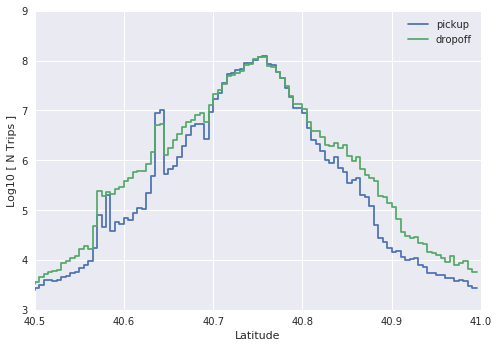

In [41]:
plt.step(bins[:-1], np.log10(h), where='pre', label='pickup')#, alpha=0.4)
plt.step(bins[:-1], np.log10(h2), where='pre', label='dropoff')#, alpha=0.4)
plt.xlim(40.5, 41.0)
plt.ylim(3, 9)
plt.ylabel("Log10 [ N Trips ]")
plt.legend(loc='upper right')
plt.xlabel('Latitude')

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


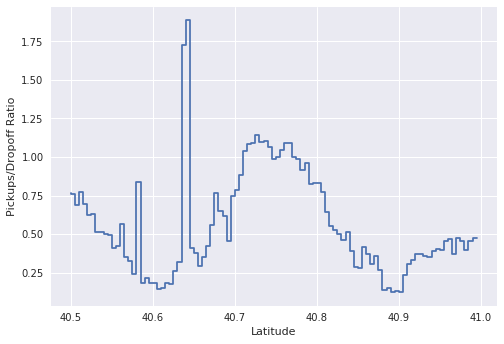

In [42]:
plt.step(bins[:-1], h/h2, where='pre')

plt.ylabel("Pickups/Dropoff Ratio")
plt.xlabel('Latitude')

In [46]:
h, bins = dask.array.histogram(df2.pickup_longitude.values, bins=np.linspace(-74.2, -73.7, 101))
h = h.compute()

h2, bins = dask.array.histogram(df2.dropoff_longitude.values, bins=np.linspace(-74.2, -73.7, 101))
h2 = h2.compute()

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


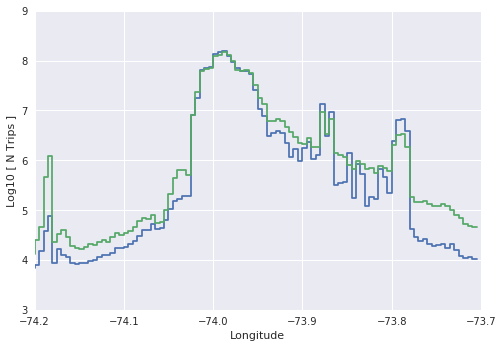

In [47]:
plt.step(bins[:-1], np.log10(h), where='pre', label='pickup')#, alpha=0.4)
plt.step(bins[:-1], np.log10(h2), where='pre', label='dropoff')#, alpha=0.4)
plt.xlim(-74.2, -73.7)
plt.ylim(3, 9)
plt.ylabel("Log10 [ N Trips ]")
plt.xlabel('Longitude')

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


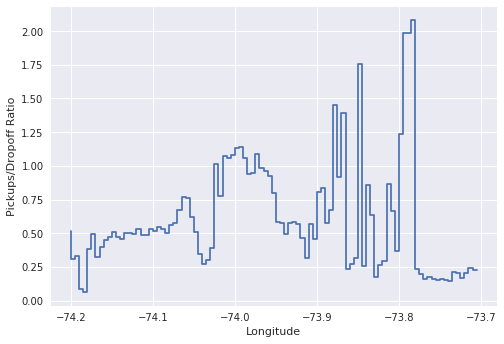

In [48]:
plt.step(bins[:-1], h/h2, where='pre')
plt.ylabel("Pickups/Dropoff Ratio")
plt.xlabel('Longitude')